代码保存在我的[github](https://github.com/5697526/CIFAR-10-Network.git)

模型和可视化结果保存在我的网盘: https://pan.baidu.com/s/1H97zHjBM6LBvDy_4BsKO-A?pwd=9395 提取码: 9395

## 一、实验目的

本项目旨在 CIFAR - 10 数据集上训练神经网络模型，以实现图像分类任务的性能优化。通过构建不同的神经网络模型，运用多种优化策略和超参数搜索方法，以提高模型在 CIFAR - 10 数据集上的分类准确率。同时，项目还包含了对网络的可视化分析，帮助理解模型的学习过程和决策机制。


## 二、数据集介绍

### 2.1 数据集来源  


本次实验使用的 CIFAR - 10 数据集是一个广泛用于图像分类研究的公开数据集，该数据集可从 [CIFAR - 10 ](https://www.cs.toronto.edu/~kriz/cifar.html)下载。

### 2.2 数据集内容

CIFAR - 10 数据集总共包含 60,000 张 32×32 像素的彩色图像，涵盖有10个不同的类别：飞机（Airplane），汽车（Automobile），鸟（Bird），猫（Cat），鹿（Deer），狗（Dog），青蛙（Frog），马（Horse），船（Ship）和卡车（Truck）。数据集被划分为训练集和测试集两部分，其中训练集包含 50,000 张图像，每个类别有 5,000 张，测试集包含 10,000 张图像，每个类别有 1,000 张。图像采用 RGB 三通道模式，每个通道是一个 32×32 的矩阵，矩阵中的每个元素表示该通道在对应像素位置的颜色强度，取值范围为 0 - 255。


### 2.3 数据格式与存储

CIFAR - 10 数据集以二进制文件的形式存储，分为多个批次。训练集被分成 5 个数据批次（data_batch_1 - data_batch_5），每个批次包含 10,000 张图像。测试集则存储在一个单独的文件（test_batch）中。每个数据批次文件包含图像数据和对应的标签，图像数据以一维数组的形式存储。

## 三、实验准备

### 3.1 依赖安装

确保已经安装了 Python 环境，并且安装必要的 Python 库。

### 3.2 数据加载

`utils\dataloader.py`使用 torchvision 包加载 CIFAR - 10 数据集，并进行预处理，包括将图像转换为张量和归一化操作。

In [ ]:
def get_dataloaders(batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

## 四、项目构建

### 4.1 必需组件

#### (1) 全连接层 Fully-Connected layer

全连接层用于最终的分类任务，将卷积层提取的特征映射转换为类别概率。

在 models/model.py 中，BasicCNN 模型的全连接层代码如下：

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=10):
        # ...
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        # ...

    def forward(self, x):
        # ...
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

在 models/model_optimized.py 中，ConfigurableCNN 模型的全连接层代码如下，其配置可以根据不同的 fc_units 进行调整：

In [ ]:
class ConfigurableCNN(nn.Module):
    def __init__(self, num_classes=10, filter_config=None, fc_units=None):
        # ...
        if fc_units is None:
            fc_units = [512, num_classes]
        self.fc1 = nn.Linear(feature_dim, fc_units[0])
        self.fc2 = nn.Linear(fc_units[0], fc_units[1])
        # ...

    def forward(self, x):
        # ...
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#### (2) 二维卷积层 2D convolutional layer

二维卷积层用于特征提取。

在 BasicCNN 模型中，定义了三个二维卷积层 self.conv1、self.conv2 和 self.conv3：

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=10):
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # ...

在 ConfigurableCNN 模型中，使用 nn.ModuleList 动态创建二维卷积层：

In [ ]:
class ConfigurableCNN(nn.Module):
    def __init__(self, num_classes=10, filter_config=None, fc_units=None):
        # ...
        self.convs = nn.ModuleList()
        in_channels = 3
        for i, out_channels in enumerate(filter_config):
            self.convs.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            in_channels = out_channels
        # ...

#### (3) 二维池化层 2D pooling layer

二维池化层通常使用 nn.MaxPool2d 进行下采样，其作用是减少特征图的尺寸，同时保留重要的特征信息，降低计算量和模型的复杂度。

二维池化层在 BasicCNN 和 ConfigurableCNN 模型中都有使用：

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=10):
        # ...
        self.pool = nn.MaxPool2d(2, 2)
        # ...

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        # ...


class ConfigurableCNN(nn.Module):
    def __init__(self, num_classes=10, filter_config=None, fc_units=None):
        # ...
        self.pool = nn.MaxPool2d(2, 2)
        # ...

    def forward(self, x):
        for i in range(self.num_conv_layers):
            x = self.pool(self.relu(self.bns[i](self.convs[i](x))))
            # ...

#### (4) 激活函数 Activations

激活函数为神经网络引入了非线性特性，使得网络能够学习到更复杂的模式。

ReLU 激活函数在 BasicCNN 和 ConfigurableCNN 模型中都有使用：

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self, num_classes=10):
        # ...
        self.relu = nn.ReLU()
        # ...

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        # ...


class ConfigurableCNN(nn.Module):
    def __init__(self, num_classes=10, filter_config=None, fc_units=None):
        # ...
        self.relu = nn.ReLU()
        # ...

    def forward(self, x):
        for i in range(self.num_conv_layers):
            x = self.pool(self.relu(self.bns[i](self.convs[i](x))))
            # ...

### 4.2 可选组件

#### (1) 批量归一化层 Batch-Norm layer

批量归一化层（nn.BatchNorm2d）用于加速模型的训练过程并提高模型的稳定性。在 model_optimized.py 中的 ConfigurableCNN 模型使用了该层。

In [ ]:
class ConfigurableCNN(nn.Module):
    def __init__(self, num_classes=10, filter_config=None, fc_units=None):
        # ...
        self.bns = nn.ModuleList()
        in_channels = 3
        for i, out_channels in enumerate(filter_config):
            self.convs.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            self.bns.append(nn.BatchNorm2d(out_channels))
            in_channels = out_channels
        # ...

    def forward(self, x):
        for i in range(self.num_conv_layers):
            x = self.pool(self.relu(self.bns[i](self.convs[i](x))))
            # ...

#### (2) Dropout 层

Dropout 层是一种防止模型过拟合的有效方法。在 model_optimized.py 中的 ConfigurableCNN 模型使用了 nn.Dropout 层。

In [ ]:
class ConfigurableCNN(nn.Module):
    def __init__(self, num_classes=10, filter_config=None, fc_units=None):
        # ...
        self.dropout = nn.Dropout(0.25)
        # ...

    def forward(self, x):
        for i in range(self.num_conv_layers):
            x = self.pool(self.relu(self.bns[i](self.convs[i](x))))
            x = self.dropout(x)
        # ...

#### (3) 残差连接 Residual Connection

残差连接有助于解决深度神经网络中的梯度消失和梯度爆炸问题。在 model.py 中的 ResNet 模型使用了残差连接，通过 ResidualBlock 类实现。

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        # ...
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        # ...

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # 残差连接
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        # ...
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        # ...

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # ...

### 4.3 必需优化策略

#### (1) 不同数量的神经元 / 滤波器

在 model_optimized.py 中，定义了不同的滤波器配置方案 FILTER_CONFIGS 和全连接层配置 FC_UNITS_CONFIGS，可以通过调整这些配置来改变模型的容量和复杂度。

In [ ]:
FILTER_CONFIGS = {
    "small": [16, 32, 64],       # 小容量网络
    "medium": [32, 64, 128],     # 中等容量网络(原始配置)
    "large": [64, 128, 256],     # 大容量网络
    "wide": [32, 128, 256],      # 宽卷积网络
    "deep": [32, 64, 128, 256]   # 深度卷积网络，4层卷积
}

FC_UNITS_CONFIGS = {
    "default": [512, 10],        # 原始配置
    "simplified": [256, 10],     # 简化全连接层
    "complex": [1024, 512, 10]   # 复杂全连接层
}

#### (2) 不同的损失函数和正则化

在 utils/loss_utils.py 中，定义了多种损失函数和正则化方法。

**焦点损失（Focal Loss）：**

主要用于解决数据集中类别不平衡的问题。在类别不平衡的情况下，模型可能会偏向于多数类，而焦点损失通过降低容易分类样本的权重，使得模型更加关注难分类的样本。

In [ ]:

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

**标签平滑损失（Label Smoothing Loss）：**

用于防止模型过拟合。传统的交叉熵损失会让模型对正确标签的预测概率趋近于 1，而标签平滑损失通过将真实标签的概率分布进行平滑，使得模型学习到更泛化的特征。

In [ ]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=10, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, inputs, targets):
        inputs = inputs.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(inputs)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, targets.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * inputs, dim=self.dim))

**L1 正则化（L1 Regularization）：**

用于防止模型过拟合，通过在损失函数中添加模型权重的 L1 范数，使得模型的权重更加稀疏，即部分权重趋近于 0。


In [ ]:
class L1Regularization(nn.Module):
    def __init__(self, model, lambda_l1=1e-4):
        super(L1Regularization, self).__init__()
        self.model = model
        self.lambda_l1 = lambda_l1

    def forward(self):
        l1_loss = 0
        for param in self.model.parameters():
            if param.requires_grad and len(param.shape) > 1:  
                l1_loss += torch.norm(param, 1)
        return self.lambda_l1 * l1_loss

**L2 正则化（L2 Regularization，权重衰减）：**

同样用于防止模型过拟合，通过在损失函数中添加模型权重的 L2 范数，使得模型的权重不会过大。

In [ ]:
class L2Regularization(nn.Module):
    def __init__(self, model, lambda_l2=5e-4):
        super(L2Regularization, self).__init__()
        self.model = model
        self.lambda_l2 = lambda_l2

    def forward(self):
        l2_loss = 0
        for param in self.model.parameters():
            if param.requires_grad and len(param.shape) > 1:  
                l2_loss += torch.norm(param, 2)
        return self.lambda_l2 * l2_loss

**组合损失函数（CombinedLoss）：**

支持同时使用多种损失函数和正则化项，将基础损失函数的结果与 L1 和 L2 正则化项的结果相加。


In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, base_loss, l1_reg=None, l2_reg=None):
        super(CombinedLoss, self).__init__()
        self.base_loss = base_loss
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg

    def forward(self, outputs, targets):
        loss = self.base_loss(outputs, targets)
        if self.l1_reg:
            loss += self.l1_reg()
        if self.l2_reg:
            loss += self.l2_reg()
        return loss

#### (3) 不同的激活函数

项目中使用了五种不同的激活函数，包括RELU、Swish、Mish、SELU、GELU，并使用激活函数工厂 get_activation 根据配置创建不同的激活函数。

在 models/activations.py 中定义：

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


class SELU(nn.Module):
    def forward(self, x):
        return F.selu(x)


class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(2 / torch.tensor(torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))


def get_activation(activation_type='relu'):
    if activation_type == 'relu':
        return nn.ReLU()
    elif activation_type == 'swish':
        return Swish()
    elif activation_type == 'mish':
        return Mish()
    elif activation_type == 'selu':
        return SELU()
    elif activation_type == 'gelu':
        return GELU()
    else:
        raise ValueError(f"不支持的激活函数类型: {activation_type}")

### 4.4 可选优化策略

#### (1) 不同的优化器

使用 torch.optim 提供的不同优化器，如 SGD、Adam 和 RMSprop。在 train.py、train_optimized.py 和 train_custom_optimizer.py 中，根据不同的配置选择不同的优化器。

在 train.py 中使用 SGD 优化器：

In [ ]:
def main():
    # ...
    optimizer = optim.SGD(
        model.parameters(),
        lr=learning_rate,
        momentum=0.9,
        weight_decay=weight_decay
    )
    # ...

在 train_optimized.py 中使用 Adam 优化器：

In [ ]:
def main():
    # ...
    if config["optimizer"] == "adam":
        optimizer = optim.Adam(
            model.parameters(),
            lr=config["learning_rate"],
            betas=(config["beta1"], config["beta2"]),
            eps=config["eps"],
            weight_decay=config["weight_decay"] if config["use_l2"] else 0
        )
    # ...

#### (2) 自定义优化器

在 utils/custom_optimizer.py 中实现了自定义优化器 CustomOptimizer，结合了动量、二阶矩估计和权重衰减等功能。

In [ ]:
class CustomOptimizer(Optimizer):
    def __init__(self, params, lr=0.01, beta1=0.9, beta2=0.999,
                 epsilon=1e-8, weight_decay=0, momentum=0, nesterov=False):
        # ...
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, epsilon=epsilon,
                        weight_decay=weight_decay, momentum=momentum, nesterov=nesterov)
        super(CustomOptimizer, self).__init__(params, defaults)
    # ...

    @torch.no_grad()
    def step(self, closure=None):
        # ...
        for group in self.param_groups:
            lr = group['lr']
            beta1 = group['beta1']
            beta2 = group['beta2']
            epsilon = group['epsilon']
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                # ...

### 4.5 网络可视化

#### (1) 滤波器可视化

在 visualize_network.py 中，使用 visualize_filters 函数可视化卷积层的滤波器，帮助理解模型学习到的特征模式。

In [ ]:
def main():
    # ...
    print("可视化卷积层滤波器...")
    fig = visualize_filters(model, 'conv1', num_cols=8, figsize=(12, 12))
    plt.savefig('./visualizations/conv1_filters.png')
    plt.close(fig)

    fig = visualize_filters(model, 'conv2', num_cols=8, figsize=(12, 12))
    plt.savefig('./visualizations/conv2_filters.png')
    plt.close(fig)
    # ...

#### (2) 特征图可视化

同样在 visualize_network.py 中，使用 visualize_feature_maps 函数可视化输入图像通过指定卷积层后的特征图，展示模型在不同层提取的特征信息。

In [ ]:
def main():
    # ...
    print("可视化特征图...")
    fig = visualize_feature_maps(
        model, 'conv1', images[0], num_cols=8, figsize=(12, 12))
    plt.savefig('./visualizations/conv1_feature_maps.png')
    plt.close(fig)

    fig = visualize_feature_maps(
        model, 'conv2', images[0], num_cols=8, figsize=(12, 12))
    plt.savefig('./visualizations/conv2_feature_maps.png')
    plt.close(fig)
    # ...

#### (3) 显著性图可视化

使用 visualize_saliency 函数可视化模型关注的图像区域，帮助理解模型的决策过程。

In [ ]:
def main():
    # ...
    print("可视化显著性图...")
    for i in range(min(5, len(images))):  # 可视化前5张图像
        fig = visualize_saliency(
            model, images[i], target_class=labels[i].item())
        plt.savefig(f'./visualizations/saliency_map_{i}.png')
        plt.close(fig)
    # ...

#### (4) 损失景观可视化

使用 plot_loss_landscape 函数可视化模型的损失景观，展示模型在参数空间中的损失变化情况。

In [ ]:
def main():
    # ...
    print("可视化损失景观...")
    fig = plot_loss_landscape(
        model, testloader, device, num_points=10, figsize=(10, 8))
    plt.savefig('./visualizations/loss_landscape.png')
    plt.close(fig)
    # ...

#### (4) Grad - CAM 可视化

在 visualize_grad_cam.py 中，使用 visualize_grad_cam 函数可视化模型的 Grad - CAM 结果，突出显示对模型决策最重要的图像区域。

In [ ]:
def main():
    # ...
    for i in range(10):
        images, labels = dataiter.next()
        image = images[0].to(device)
        fig = visualize_grad_cam(
            model,
            image,
            target_layer='conv3',
            class_names=classes,
            figsize=(12, 4)
        )
        plt.savefig(f'./grad_cam_visualizations/grad_cam_{i}.png')
        plt.close(fig)
    # ...

## 五、实验过程

### 5.1 超参数搜索

使用 hyperparameter_search_main.py 脚本进行超参数搜索，可以选择随机搜索或贝叶斯优化方法。


In [ ]:
def main():
    parser = argparse.ArgumentParser(description='CIFAR-10 超参数搜索')
    parser.add_argument('--method', type=str, default='random', choices=['random', 'bayesian'],
                        help='超参数搜索方法 (random 或 bayesian)')
    parser.add_argument('--trials', type=int, default=20,
                        help='试验次数')
    parser.add_argument('--initial_random', type=int, default=5,
                        help='贝叶斯优化的初始随机试验次数')
    parser.add_argument('--save_dir', type=str, default='./hyperparameter_search',
                        help='保存搜索结果的目录')
    args = parser.parse_args()

    trainloader, testloader = get_dataloaders(batch_size=32)

    if args.method == 'random':
        search = RandomSearch(
            model_builder=ConfigurableCNN,
            dataloaders=(trainloader, testloader),
            num_trials=args.trials,
            save_dir=args.save_dir
        )
    else:  # bayesian
        search = BayesianOptimization(
            model_builder=ConfigurableCNN,
            dataloaders=(trainloader, testloader),
            num_trials=args.trials,
            num_initial_random=args.initial_random,
            save_dir=args.save_dir
        )

    search.run()


if __name__ == '__main__':
    main()

### 5.2 模型训练

可以使用不同的训练脚本来训练模型，如 train.py、train_optimized.py、train_component_optimizers.py 和 train_custom_optimizer.py。这些脚本中包含了不同的优化策略和超参数配置。

**train.py：**

使用基本模型 BasicCNN 进行训练，采用了随机梯度下降（SGD）优化器和交叉熵损失函数。

**train_optimized.py：**

使用优化模型 ConfigurableCNN 进行训练，采用了 Adam 优化器和组合损失函数。

**train_component_optimizers.py：**

使用优化模型 ConfigurableCNN 进行训练，为模型的不同层（卷积层和全连接层）使用不同的优化器。

**train_custom_optimizer.py：**

使用优化模型 ConfigurableCNN ，使用自定义的优化器CustomOptimizer进行训练。

此处展示 train_optimized.py 的部分示例：

In [ ]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    config = {
        "filter_config": "wide",
        "fc_units": "default",
        "activation": "mish",
        "loss_type": "ls",
        "focal_alpha": 1,
        "focal_gamma": 2,
        "ls_smoothing": 0,
        "use_l1": False,
        "lambda_l1": 1e-4,
        "use_l2": True,
        "lambda_l2": 0.0001,
        "num_epochs": 30,
        "batch_size": 128,
        "optimizer": "adam",
        "learning_rate": 0.001,
        "momentum": 0,
        "weight_decay": 0.0001,
        "beta1": 0.9,
        "beta2": 0.999,
        "eps": 1e-8
    }

    trainloader, testloader = get_dataloaders(config["batch_size"])
    model = ConfigurableCNN(
        num_classes=10,
        filter_config=FILTER_CONFIGS[config["filter_config"]],
        fc_units=FC_UNITS_CONFIGS[config["fc_units"]]
    ).to(device)

    base_loss = get_loss_function(
        loss_type=config["loss_type"],
        alpha=config["focal_alpha"],
        gamma=config["focal_gamma"],
        smoothing=config["ls_smoothing"]
    )
    l1_reg = L1Regularization(
        model, config["lambda_l1"]) if config["use_l1"] else None
    l2_reg = L2Regularization(
        model, config["lambda_l2"]) if config["use_l2"] else None
    criterion = CombinedLoss(base_loss, l1_reg, l2_reg)

    optimizer = optim.Adam(
        model.parameters(),
        lr=config["learning_rate"],
        betas=(config["beta1"], config["beta2"]),
        eps=config["eps"],
        weight_decay=config["weight_decay"] if config["use_l2"] else 0
    )
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=config["num_epochs"])

    best_acc = 0.0
    for epoch in range(config["num_epochs"]):
        train_loss = train(model, device, trainloader,
                           criterion, optimizer, epoch)
        test_acc = evaluate(model, device, testloader)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'config': config,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'accuracy': test_acc
            }, './results/best_model.pth')

        scheduler.step()
        print(
            f'Epoch {epoch+1}/{config["num_epochs"]}, Train Loss: {train_loss:.4f}, Test Acc: {test_acc:.2f}%')

    print(f'Best test accuracy: {best_acc:.2f}%')



### 5.3 结果分析

使用 analyze_search_results.py 脚本分析超参数搜索结果，包括最佳配置的选择、准确率分布的可视化和参数相关性分析。



In [ ]:
def analyze_results(results_file, save_dir='./search_analysis'):
    os.makedirs(save_dir, exist_ok=True)
    df = pd.read_csv(results_file)

    best_config = df.loc[df['best_accuracy'].idxmax()]
    print("最佳配置:")
    print(best_config)
    best_config.to_csv(os.path.join(save_dir, 'best_config.csv'))

    plt.figure(figsize=(10, 6))
    sns.histplot(df['best_accuracy'], kde=True)
    plt.title('准确率分布')
    plt.xlabel('准确率 (%)')
    plt.ylabel('试验次数')
    plt.savefig(os.path.join(save_dir, 'accuracy_distribution.png'))
    plt.close()

    categorical_params = ['filter_config', 'fc_units',
                          'activation', 'optimizer', 'loss_type']
    for param in categorical_params:
        if param in df.columns:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=param, y='best_accuracy', data=df)
            plt.title(f'{param} 对准确率的影响')
            plt.savefig(os.path.join(save_dir, f'{param}_vs_accuracy.png'))
            plt.close()

    continuous_params = ['learning_rate', 'momentum', 'weight_decay', 'batch_size',
                         'focal_alpha', 'focal_gamma', 'ls_smoothing']
    for param in continuous_params:
        if param in df.columns:
            plt.figure(figsize=(10, 6))
            sns.scatterplot(x=param, y='best_accuracy', data=df)
            plt.title(f'{param} 对准确率的影响')
            plt.savefig(os.path.join(save_dir, f'{param}_vs_accuracy.png'))
            plt.close()

    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    corr = numeric_df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('参数相关性分析')
    plt.savefig(os.path.join(save_dir, 'correlation_heatmap.png'))
    plt.close()

    print(f"分析完成，结果保存在 {save_dir} 目录中")

项目还提供了网络可视化的功能，包括滤波器可视化、特征图可视化、显著性图可视化、损失景观可视化和 Grad - CAM 可视化，在报告前面的内容里有提及如何实现。

运行 visualize_network.py 和 visualize_grad_cam.py 代码即可进行所有可视化操作。

## 六、实验结果

### 6.1 超参数搜索结果

对超参数搜索的过程进行可视化，包括最佳配置的选择、准确率分布的可视化和参数相关性分析。以下是可视化结果：

将超参数搜索中各个试验的最佳准确率分布情况进行可视化：

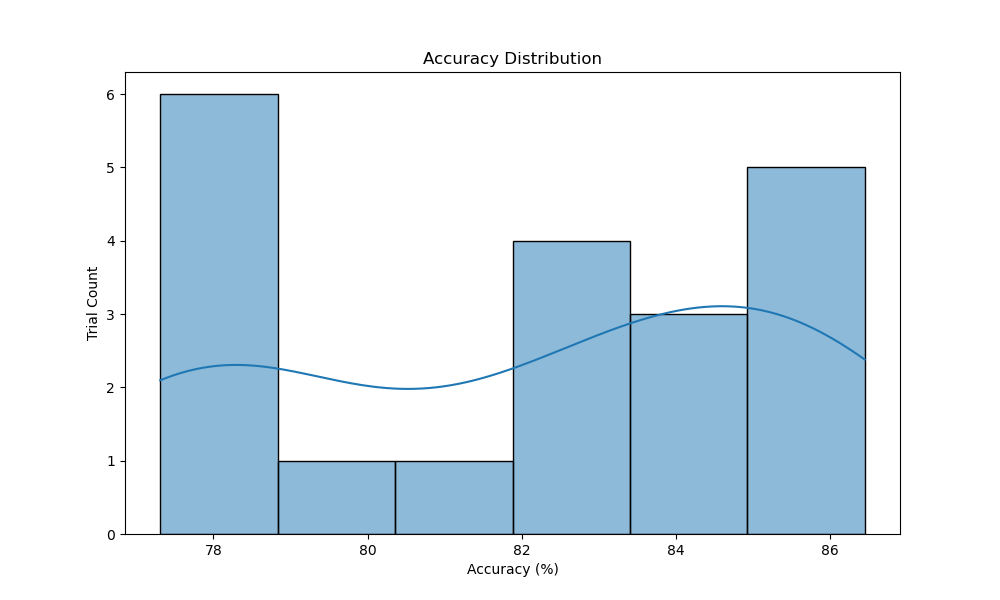

对于分类参数（如filter_config、fc_units、activation、optimizer、loss_type），使用seaborn库的boxplot函数绘制箱线图，展示不同参数取值下的准确率分布。此处展示filter_config的准确率分布：

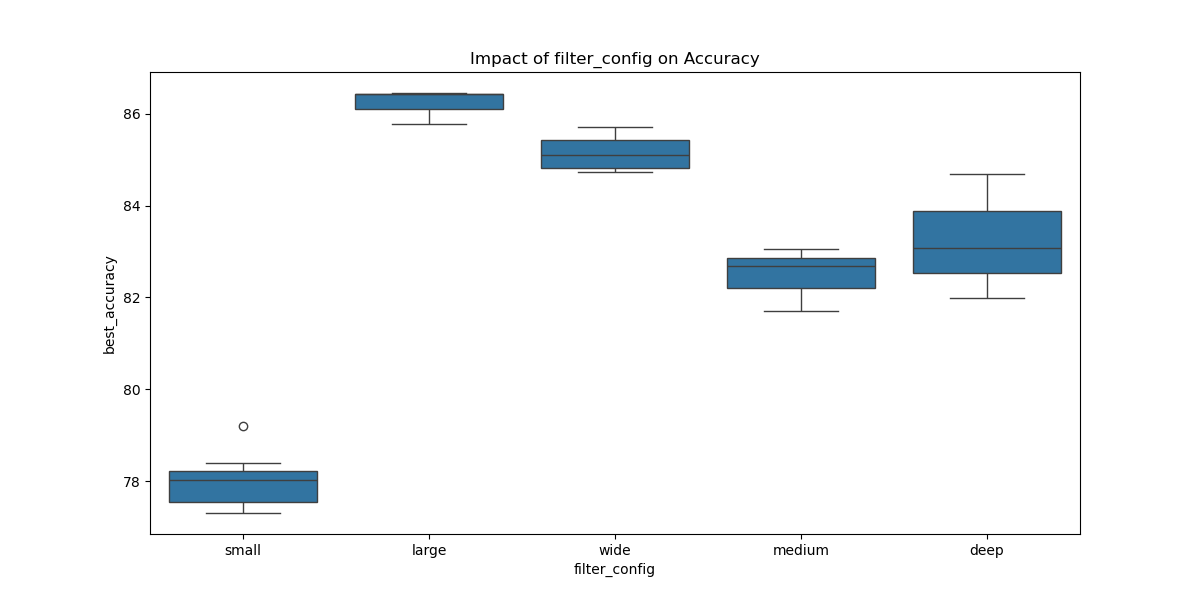

对于连续参数（如learning_rate、momentum、weight_decay、batch_size、focal_alpha、focal_gamma、ls_smoothing），使用seaborn库的scatterplot函数绘制散点图，展示参数值与准确率之间的关系。此处展示ls_smoothing 的散点图：

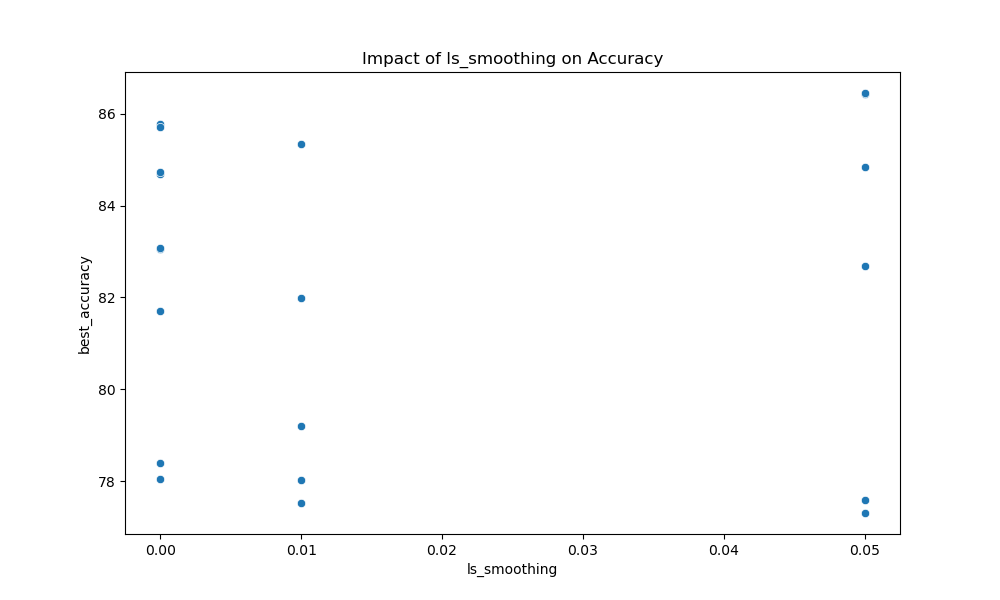

使用seaborn库的heatmap函数绘制热力图，展示所有数值型参数之间的相关性：

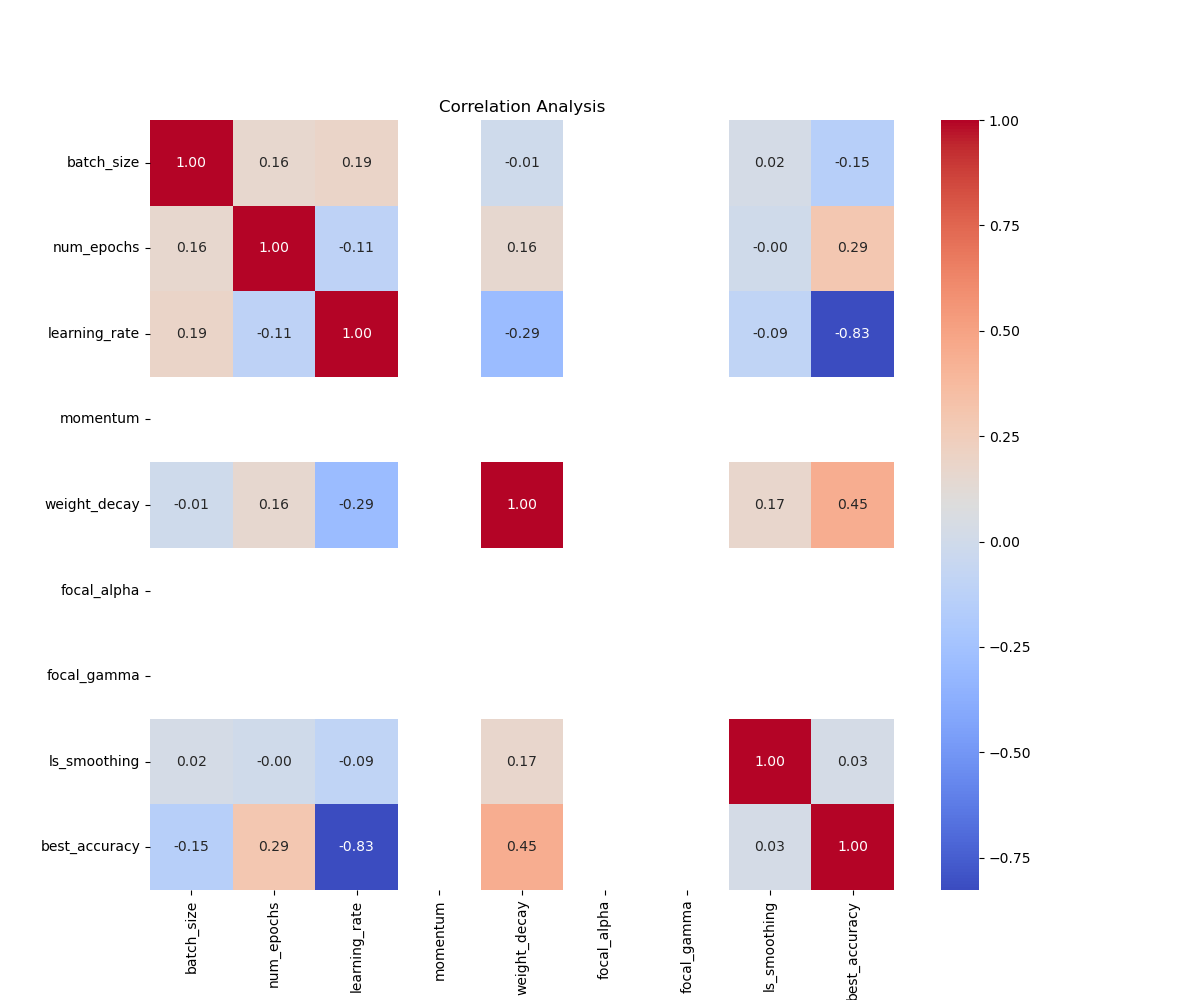

经过超参数搜索和模型训练，最终获得的最佳测试准确率为 86.45%，对应的配置如下：

filter_config: large

fc_units: default

activation: mish

batch_size: 192

num_epochs: 35

optimizer: adam

learning_rate: 0.001

momentum: 0

weight_decay: 0.00015

loss_type: ls

focal_alpha: 1

focal_gamma: 2

ls_smoothing: 0.05

Best accuracy: 86.45%

### 6.2 模型可视化结果

**卷积层滤波器可视化**

通过可视化卷积层的滤波器，可以观察到滤波器学习到的不同特征模式，如边缘、纹理等。此处可视化了模型的第 1 层和第 2 层卷积层的滤波器。

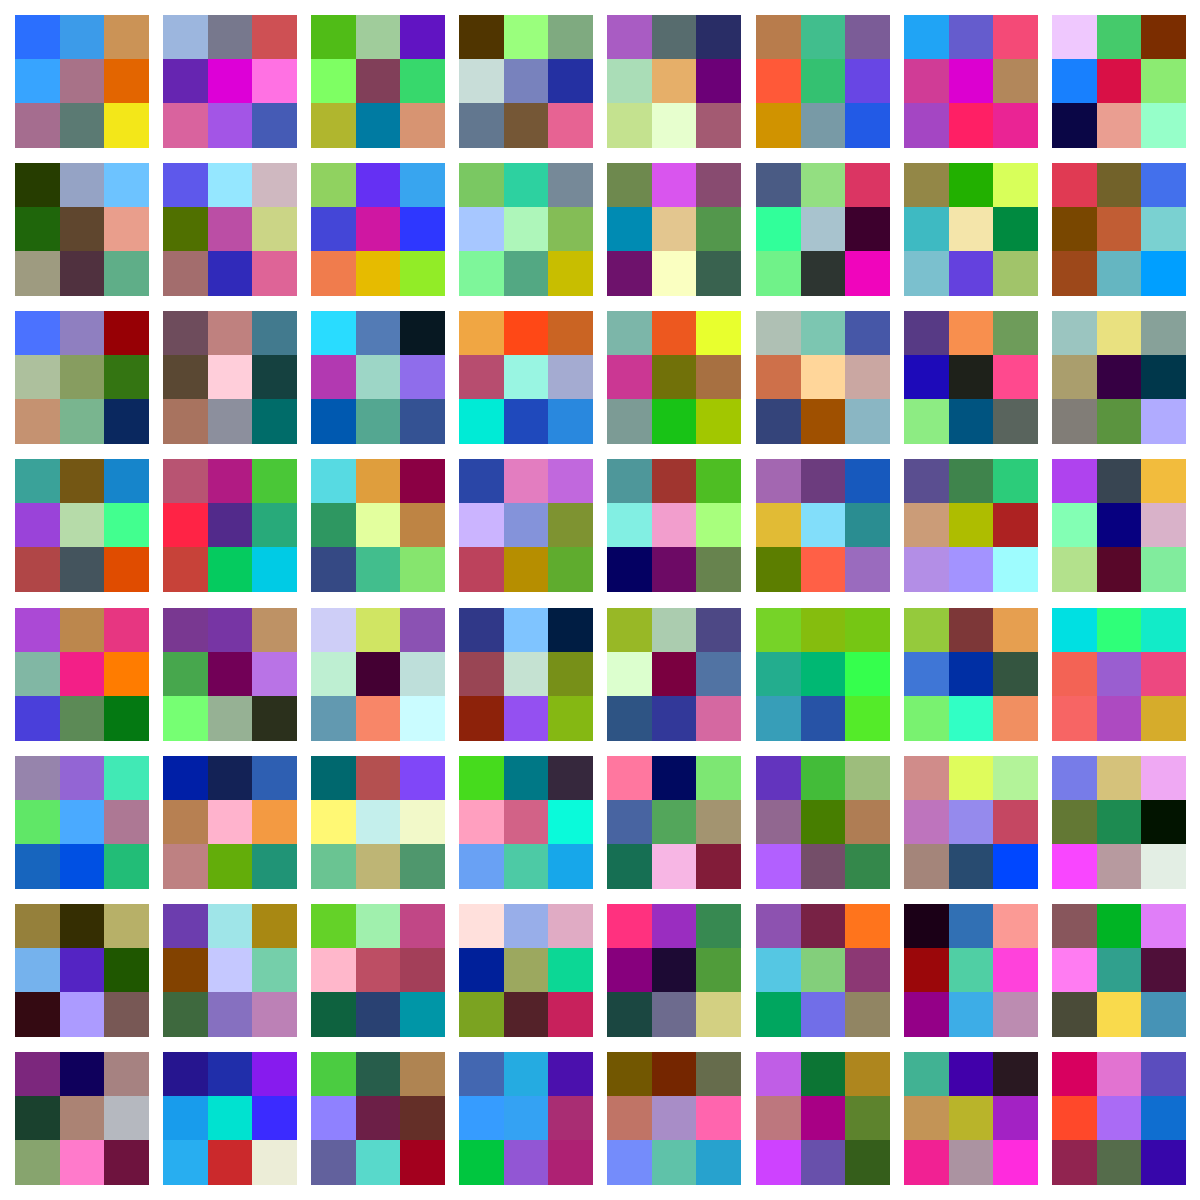

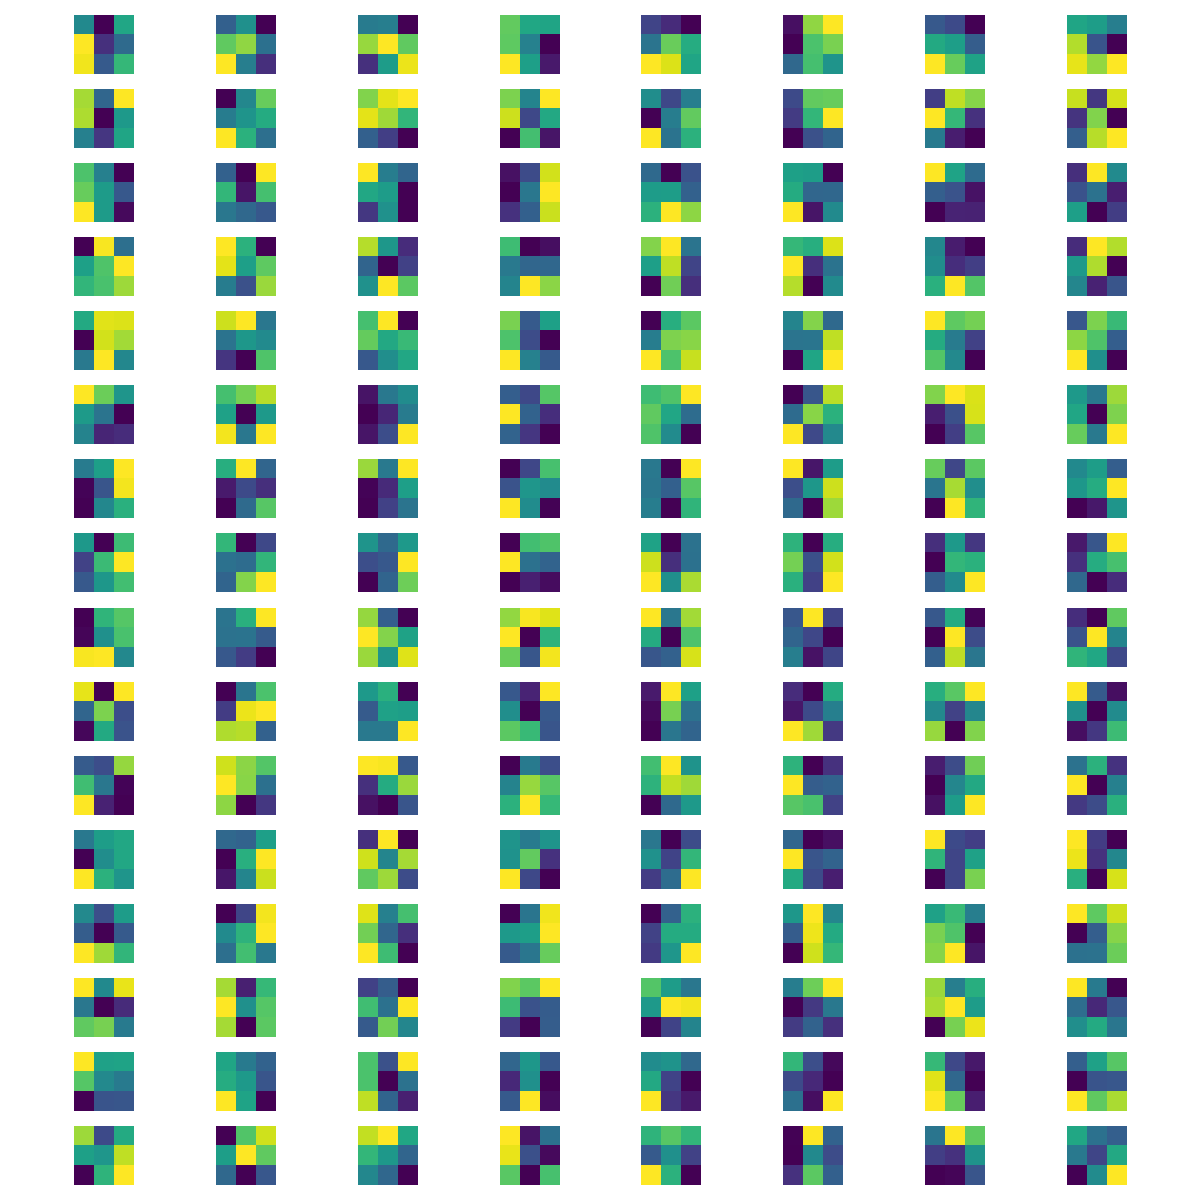

**特征图可视化**

特征图可视化展示了图像在经过卷积层后提取的特征，有助于理解模型的特征提取过程。此处可视化了图像在经过模型的第 1 层和第 2 层后提取的特征。


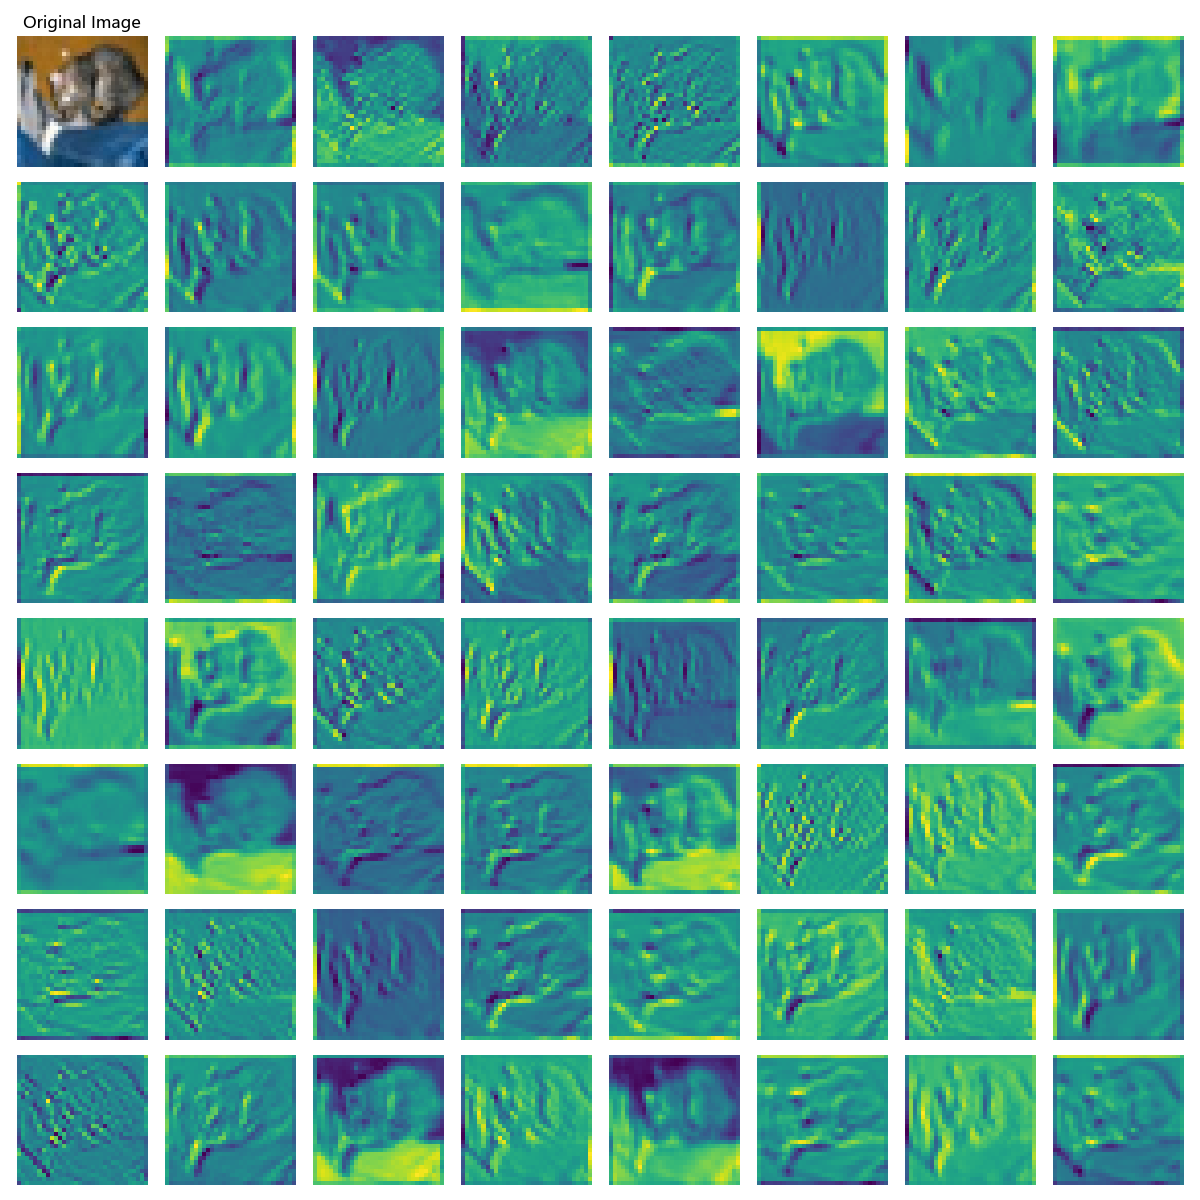

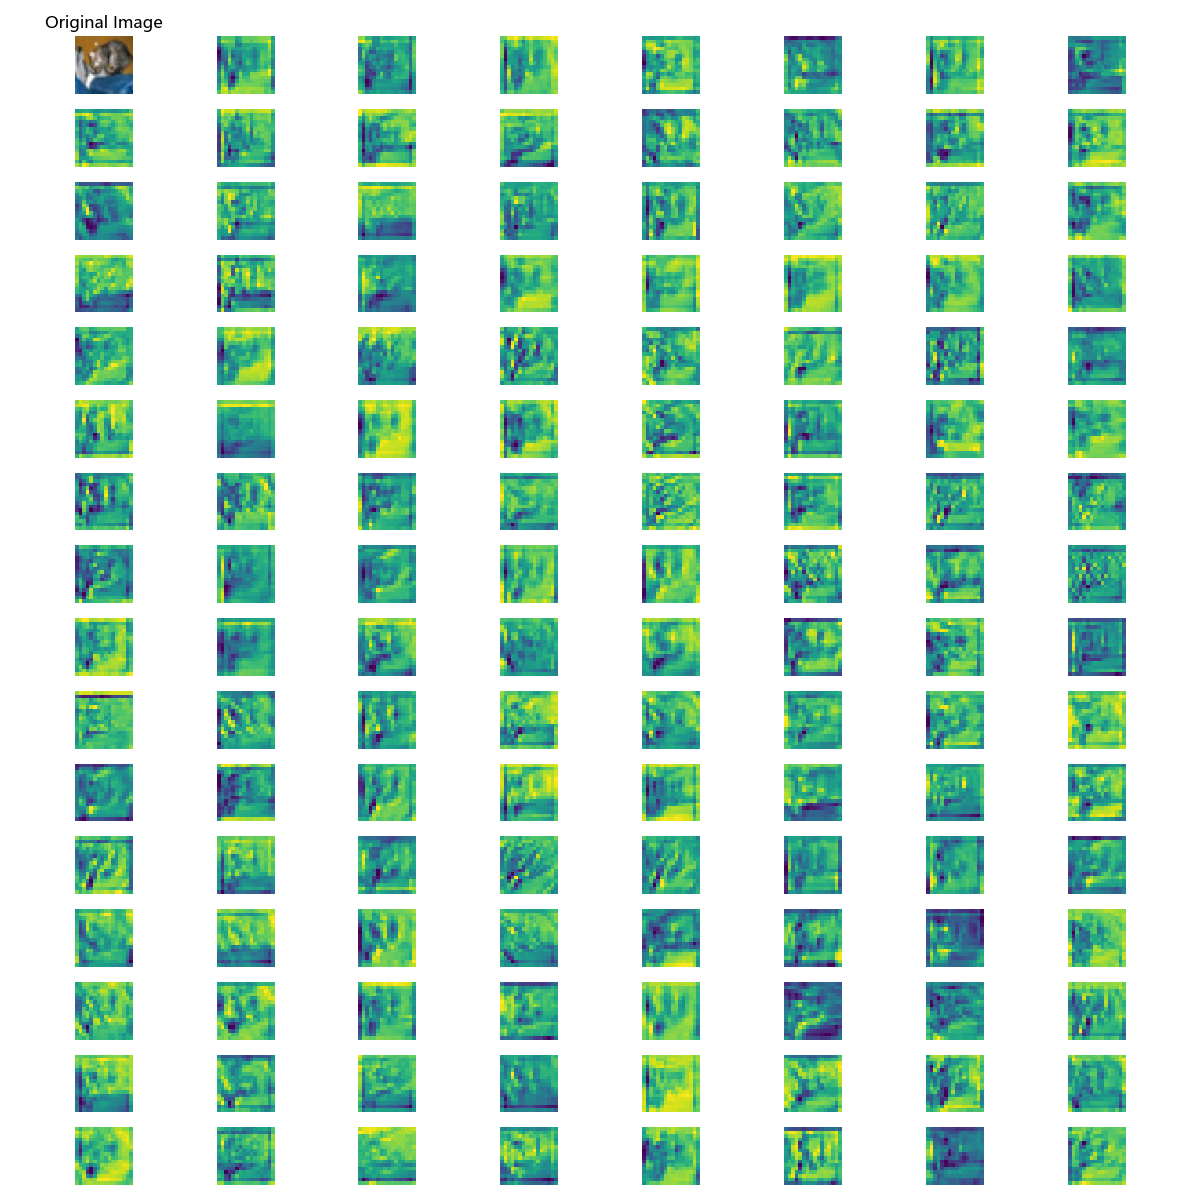

**显著性图可视化**

显著性图显示了图像中对模型预测最重要的区域，帮助分析模型的决策依据。此处可视化了前5张图像，仅展示前两张。

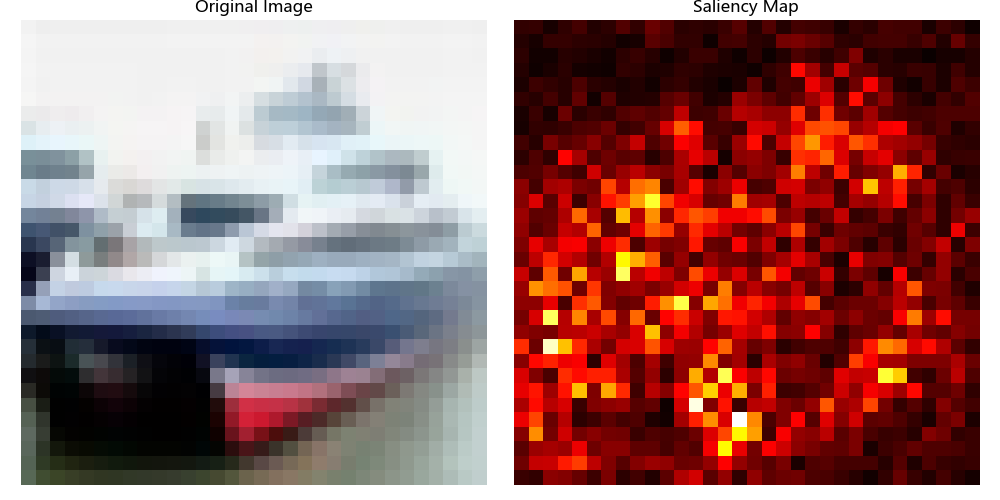 

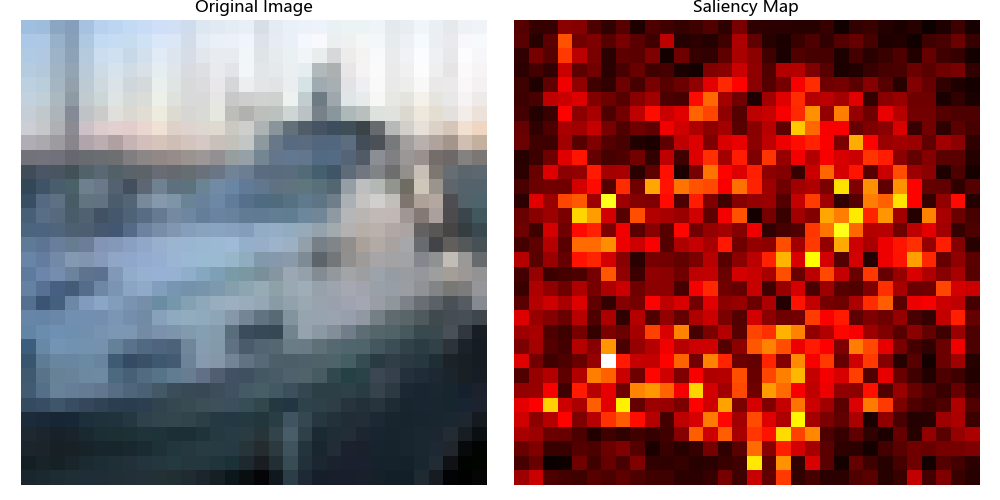


**损失景观可视化**

损失景观可视化展示了模型在参数空间中的损失分布，有助于理解模型的优化过程和收敛情况。

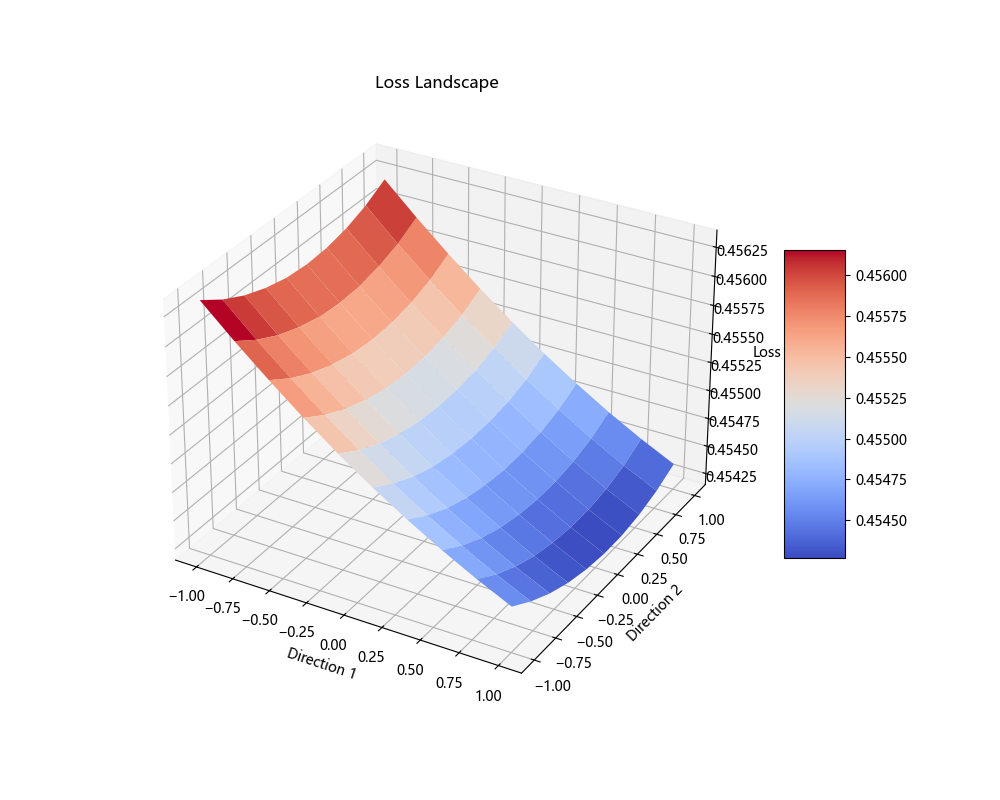

** Grad - CAM 可视化**

Grad - CAM 可视化突出了模型在预测时关注的区域，提供了模型决策的可视化解释。此处可视化了前10张图像的Grad-CAM结果，仅展示前两张。

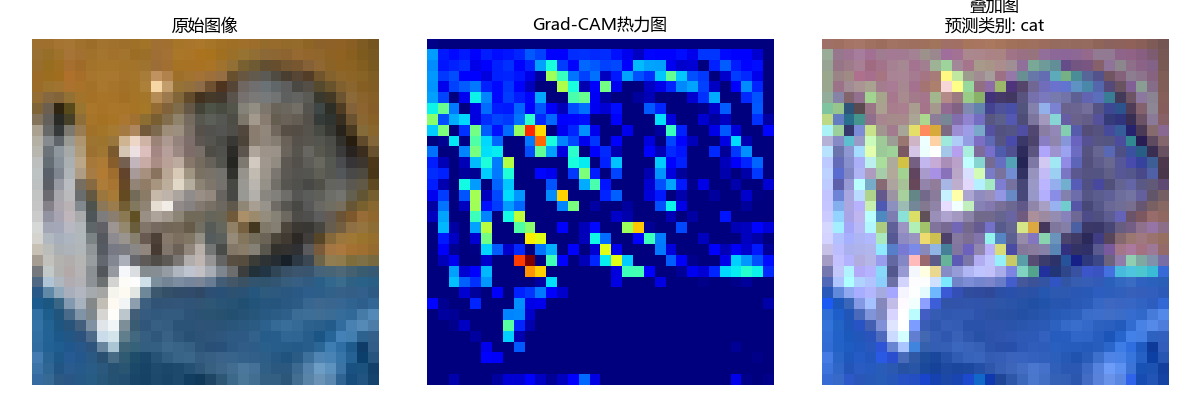

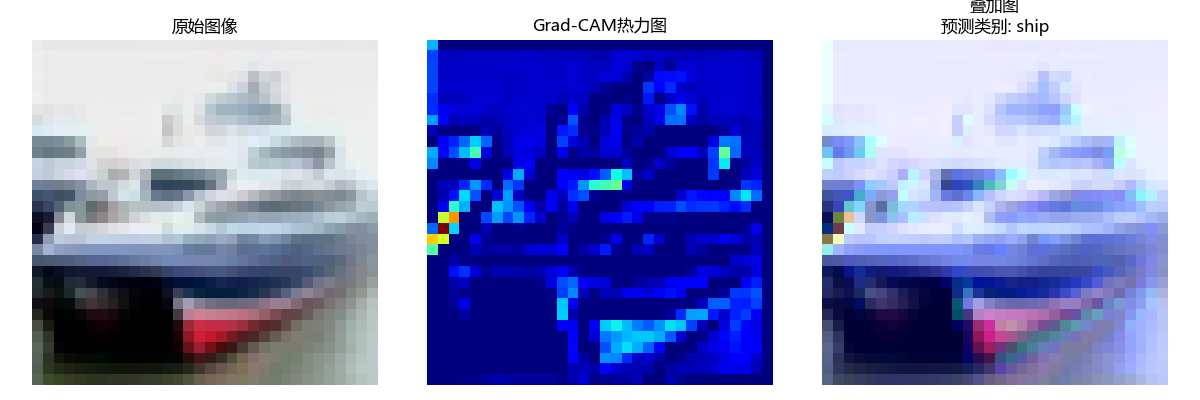

### 6.3 结果保存

实验代码保存在我的[github](https://github.com/5697526/CIFAR-10-Network.git)

模型和可视化结果保存在我的网盘: https://pan.baidu.com/s/1H97zHjBM6LBvDy_4BsKO-A?pwd=9395 提取码: 9395